In [1]:
from fastai import *
from fastai.vision import *

In [2]:
path = Path('../input/aptos2019-blindness-detection/')

In [3]:
path.ls()

[PosixPath('../input/aptos2019-blindness-detection/train.csv'),
 PosixPath('../input/aptos2019-blindness-detection/sample_submission.csv'),
 PosixPath('../input/aptos2019-blindness-detection/test.csv'),
 PosixPath('../input/aptos2019-blindness-detection/train_images'),
 PosixPath('../input/aptos2019-blindness-detection/test_images')]

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
df_test = pd.read_csv(path/'test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [6]:
print(len(df))
print(len(df_test))

3662
1928


In [7]:
src = (
    ImageList.from_df(df,path,folder='train_images',suffix='.png')
        .split_by_rand_pct(0.1, seed=42)
        .label_from_df()
    )

In [8]:
tfms = get_transforms(max_warp=0, max_zoom=1.1, max_lighting=0.1, p_lighting=0.1)

In [9]:
data = (
    src.transform(tfms,size=128)
    .databunch()
    .normalize(imagenet_stats)
)

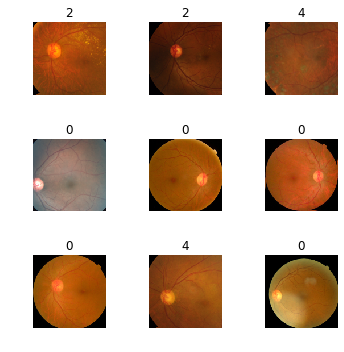

In [10]:
data.show_batch(rows=3, figsize=(5,5))

In [11]:
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

In [12]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [13]:
learn = cnn_learner(data, base_arch=models.resnet50, metrics=[error_rate, kappa], model_dir='/kaggle', pretrained=True)

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,1.079494,0.813748,0.254098,0.755783,07:07
1,0.830742,0.666341,0.221311,0.815908,07:09
2,0.708030,0.653929,0.248634,0.780331,07:04
3,0.621093,0.626703,0.210383,0.824063,07:11


In [15]:
learn.save("/kaggle/working/stage-1")

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


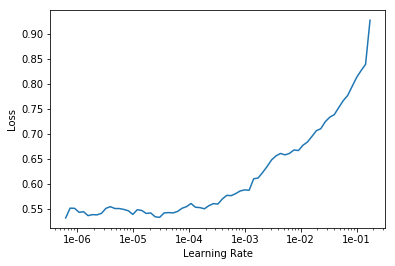

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.561242,0.618278,0.218579,0.810636,07:04
1,0.551049,0.598279,0.196721,0.826328,07:13
2,0.539451,0.592835,0.204918,0.829988,07:11
3,0.504734,0.596695,0.204918,0.818335,07:11


In [19]:
learn.save('/kaggle/working/stage-2')

In [20]:
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [21]:
learn.data.add_test(ImageList.from_df(sample_df,path,folder='test_images',suffix='.png'))

In [22]:
preds,y = learn.get_preds(DatasetType.Test)

In [23]:
sample_df.diagnosis = preds.argmax(1)
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [24]:
sample_df.to_csv('submission.csv',index=False)

In [25]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv